In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import sklearn.linear_model
import sklearn.model_selection
import pandas as pd
from sklearn.datasets.samples_generator import make_moons
from sklearn.datasets import load_iris
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings("ignore")

# Applied Machine Learning

### Estimating overfitting, bootstrapping, and ensembles

### Train/test split

- Our main goal is to measure performance properly
- Model perfect on the train set might be useless on the test set
- We never train on test data, re-using it makes it impossible to estimate the actual quality

### Who splits the data?

- Sometimes it is you
- In Kaggle you have the split made for you
- Good practice: the manager sets up the test set

- Data available for:

  Manager: train features, train labels, test features, test labels
  
  Data scientist: train features, train labels, test features
   

### Pitfalls

- Train/test is usually 80/20 but it could change if you have extreme sizes
- Train and test (ideally) should come from the same distribution
- Choosing your model based on test is actually quite wrong

### The proper split: train | validation/development (public leaderboard) | test (private leaderboard)

- When we use test set score multiple time, we actually overfit
- We need an additional dataset
- In practice, you can't use test only once
- Be very careful making decision based on test set score

### Do the distributions of test and train match?

- Theory is sure to make them identically distributed
- In practice they might differ
- e.g. test could contain images from all around the world but train could have images only from your office

### Statistical estimators and ML

- In statistics, we often estimate something: means, variances, differences of means, ...
- To see ML models as estimators just use any metric: MSE, accuracy, ...
- Estimators have two important properties: bias and variance

### Bias-variance tradeoff

- We can decompose e.g. the squared error:
$$
\mathop{E} \left[(y - \hat y)^2\right] = (\mathop{E}[y] - \hat y)^2 + (\mathop{E}[y]^2 - \mathop{E}[\hat y]^2) + \mathsf{irreducible~error}
$$
- The $(\mathop{E}[y] - \hat y)$ term is called bias
- The $(\mathop{E}[y]^2 - \mathop{E}[\hat y]^2)$ term is called variance
- There is a tradeoff as you can't have both low bias and low variance

### Estimator with high bias

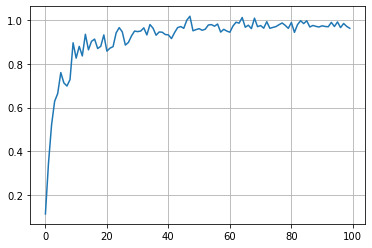

In [3]:
def biased_estimator(values):
    return (values.sum()) / (len(values) + 100) 

ys = [biased_estimator(np.random.randn(i) + 1.0) for i in range(10, 5000, 50)]
plt.plot(ys); plt.grid()

### Practical biased estimator: Laplace smoothing

- What's the probability of a digit in a sequence?
- Say the digit `7` never occured in a sequence of length 100, unbiased probability gets 0
- Let's smooth (regularize) the probability using prior probability of (1/10):

In [4]:
(0) / (100) # unbiased
(0 + 0.1) / (100 + 1) # biased

0.0009900990099009901

### Estimator with high variance

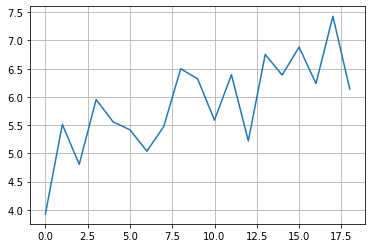

In [5]:
def high_variance_estimator(sample):
    return sample.max() - sample.min()

ys = [high_variance_estimator(np.random.randn(i)) for i in range(50, 1000, 50)]
plt.plot(ys); plt.grid()

### Bias/variance in ML

- High bias means the model never can't fit well enough
- High variance means the model is unstable in fitting it well
- Linear models have high ...? 
- Decision trees have high ...?

### Bias/variance in ML

- Reducing bias usually means changing your model somehow
- Reducing variance is possible other way
- Hint: averaging helps

### Bootstrap

- An useful *practical* trick to assign some accuracy to estimators
- The method is based on sampling *with replacement*

In [6]:
pd.Series([1, 2, 3]).sample(n=10, replace=True).mean() # not biased

2.3

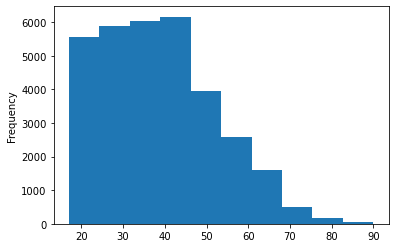

In [7]:
df = pd.read_csv('adult.csv')
df.age.plot.hist();

In [8]:
print("Mean age is %f+-[?]" % (df.age.mean()))

Mean age is 38.581647+-[?]


Generate slightly different dataset with sampling with replacement:

In [9]:
df.sample(frac=1.0, replace=True).age.mean()

38.49586929148368

Generate differents slightly datasets a few times:

In [10]:
maxes = []
for _ in range(800):
    maxes.append(df.sample(frac=0.001, replace=True).age.max())
maxes[:10]

[62, 64, 73, 60, 67, 73, 65, 75, 84, 66]

The histogram of generated maxes:

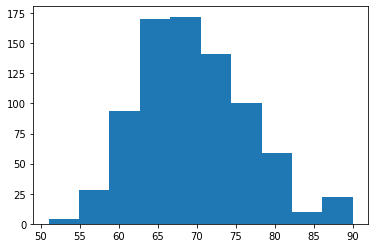

In [11]:
plt.hist(maxes);

### Confidence interval

- Bootstrapping makes CI really easy
- Given confidence level $p = 0.95$

In [12]:
p = 100
np.percentile(maxes, (100.0 - p) / 2.0), np.percentile(maxes, (100.0 + p) / 2.0)

(51.0, 90.0)

### Bootstrapping in machine learning

- We can create a few samples with bootstrapping
- This might be helpful

### The Condorcet's jury theorem

- There is a jury of $N$ individuals that make some decision
- The final decision is reached by majority vote
- The decision is either right or wrong
- How does the probability of correct decision changes if we change $N$?

### Averaging models

- We need a few models that are somehow different and independent
- Each model should be just good enough
- The more models we have, the better score we get
- Straightforward if we have a few training sets

### Bagging

- Bootstrap AGGregatING
- We use bootstrap to generate a few datasets
- On each dataset, we train a model
- These models form an ensemble:
$$f(x) = \mathop{avg}_{i} f_i(x)$$

### Random Forest

- An instance of bagging, in which we use decision trees
- One of the most popular algorithms
- Works out of box most of the time
- One slight detail - drop random features in each classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

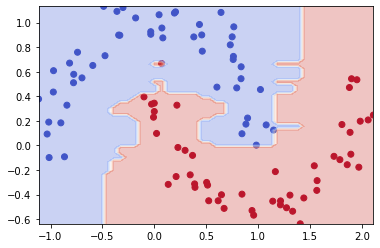

In [14]:
X,y = make_moons(100, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
rx, ry = np.linspace(X[:,0].min(), X[:,0].max(), 50), np.linspace(X[:,1].min(), X[:,1].max(), 50)
inputs = np.dstack(np.meshgrid(rx, ry))
rf = RandomForestClassifier(n_estimators=100).fit(X, y)
pc = np.apply_along_axis(lambda x: rf.predict([x]), 2, inputs)
plt.contourf(rx, ry, pc[:,:,0], alpha=0.3, cmap='coolwarm');

### Boosting

- Other way to learn a few independent classifiers
- Iterative algorithm
- We learn $f_1$ to fit the labels
- We learn $f_2$ to fit the errors between predictions of $f_1$ and $y$ (residual)
- ....
- Final model $\mathsf{avg}_{i} f_i$

### Gradient Boosting

- There is a pure beauty analogy between this algorithm and gradient descent
- The difference (residual) is actually the gradient of your loss function
- We will discuss the 'gradient' part later
- Each 'base' classifier is usually a tree, but can be a linear model (AdaBoost)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

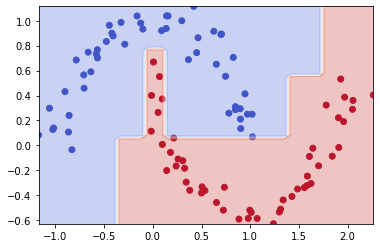

In [16]:
X,y = make_moons(100, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
rx, ry = np.linspace(X[:,0].min(), X[:,0].max(), 50), np.linspace(X[:,1].min(), X[:,1].max(), 50)
inputs = np.dstack(np.meshgrid(rx, ry))
rf = GradientBoostingClassifier(n_estimators=100).fit(X, y)
pc = np.apply_along_axis(lambda x: rf.predict([x]), 2, inputs)
plt.contourf(rx, ry, pc[:,:,0], alpha=0.3, cmap='coolwarm');

### Gradient tree boosting

- xgboost
- CatBoost
- LightGBM

These all are easy to install and have almost identical interface

### Hyperparameters

- Depth: gradient boosting needs much less than random forest
- Number of trees: a few hundreds usually suffice

### Next time

- Recommenders
- Embeddings

### Self-assessment time!

- Why do we need to split the data into three parts?
- Some person is old-fashioned in many senses. It is an example of **a) high bias b) high variance c) low bias d) low variance**
- You flipped a coin twice and it is Tails-Tails. **What's the probability, really?** 
- Random forest is usually fastest to learn, **why?**
- You trained a gradient boosting model but your most important feature is now broken. **What is going to happen?**